# Step 2 - Create subgroups using NMF

## 2.1 Create a subgroup from the abstracts corpus using NMF

In [1]:
import functions

In [2]:
functions.outputs.make_csv("/Users/manojarachige/Documents/Coding/Projects/BMedScDOC2021/BMedScDOC_2023/Assets/Abstracts_All", "txt")

In [3]:
#csv called corpus.csv saved to current working directory

In [4]:
import pandas as pd
import csv

df=pd.read_csv('corpus.csv', encoding = 'unicode_escape', encoding_errors = 'ignore', engine ='c')
print("There are a total of {} Abstracts".format(len(df)))
df.head()

There are a total of 24238 Abstracts


,name,text
0,10601807.txt,1. Eur Neurol. 2000;43(1):39-46. doi: 10.1159/...
1,10613939.txt,1. Ann Emerg Med. 2000 Jan;35(1):43-6. doi: 10...
2,10618329.txt,1. Heart. 2000 Jan;83(1):22-3. doi: 10.1136/he...
3,10618330.txt,1. Heart. 2000 Jan;83(1):24-8. doi: 10.1136/he...
4,10624990.txt,1. Anesth Analg. 2000 Jan;90(1):116-8. doi: 10...


In [5]:
df['processed_text'] = df['text'].apply(functions.processing.preprocess)
df.head()

,name,text,processed_text
0,10601807.txt,1. Eur Neurol. 2000;43(1):39-46. doi: 10.1159/...,"[eur, neurol, simultaneous, assessment, brain,..."
1,10613939.txt,1. Ann Emerg Med. 2000 Jan;35(1):43-6. doi: 10...,"[ann, emerg, med, jan, sxhypoglycemia, abcs, s..."
2,10618329.txt,1. Heart. 2000 Jan;83(1):22-3. doi: 10.1136/he...,"[heart, jan, heartdiagnosis, carotid, sinus, h..."
3,10618330.txt,1. Heart. 2000 Jan;83(1):24-8. doi: 10.1136/he...,"[heart, jan, heartclinical, features, adenosin..."
4,10624990.txt,1. Anesth Analg. 2000 Jan;90(1):116-8. doi: 10...,"[anesth, analg, jan, prolong, coma, quadripleg..."


In [6]:
df["word_count"] = df["processed_text"].apply(lambda x: len(x))
#add in a line to remove 0 wc texts
df = df[~(df.word_count == 0)]

df.head()

,name,text,processed_text,word_count
0,10601807.txt,1. Eur Neurol. 2000;43(1):39-46. doi: 10.1159/...,"[eur, neurol, simultaneous, assessment, brain,...",133
1,10613939.txt,1. Ann Emerg Med. 2000 Jan;35(1):43-6. doi: 10...,"[ann, emerg, med, jan, sxhypoglycemia, abcs, s...",163
2,10618329.txt,1. Heart. 2000 Jan;83(1):22-3. doi: 10.1136/he...,"[heart, jan, heartdiagnosis, carotid, sinus, h...",170
3,10618330.txt,1. Heart. 2000 Jan;83(1):24-8. doi: 10.1136/he...,"[heart, jan, heartclinical, features, adenosin...",203
4,10624990.txt,1. Anesth Analg. 2000 Jan;90(1):116-8. doi: 10...,"[anesth, analg, jan, prolong, coma, quadripleg...",30


In [7]:
# Descriptive statistics for word count
df['word_count'].describe()
#95%CI Calculated: 

count    23676.000000
mean       132.422242
std         89.755336
min          7.000000
25%         59.000000
50%        135.000000
75%        184.000000
max       2631.000000
Name: word_count, dtype: float64

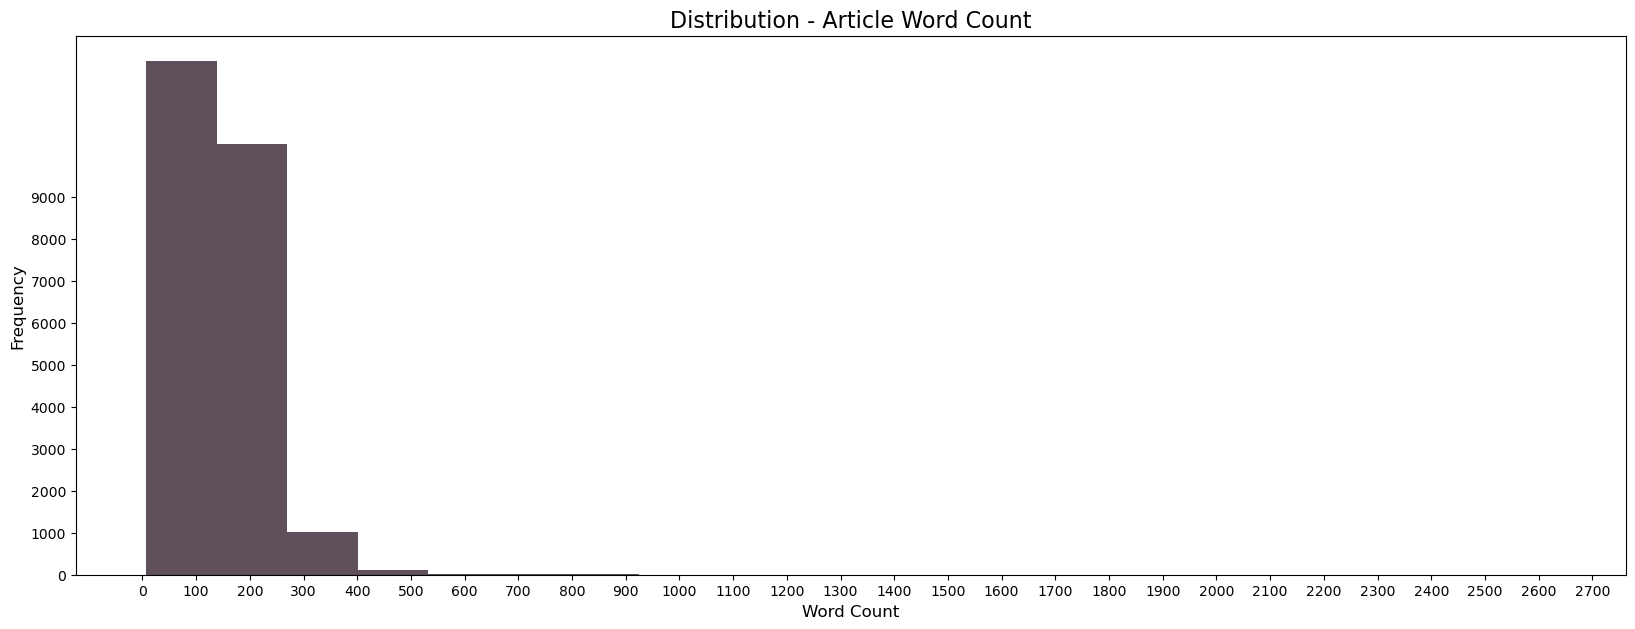

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Plot a hist of the word counts
fig = plt.figure(figsize=(20,7))

plt.hist(
    df['word_count'],
    bins=20,
    color='#60505C'
)

plt.title('Distribution - Article Word Count', fontsize=16)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Word Count', fontsize=12)
plt.yticks(np.arange(0, 10000, 1000))
plt.xticks(np.arange(0, 2800, 100))

file_name = 'hist'

plt.show()

In [9]:
from collections import Counter

# Get the top 20 most common words among all the articles
p_text = df['processed_text']

# Flaten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),
    columns=['word', 'frequency']
)

top_20

,word,frequency
0,patient,54725
1,university,29612
2,medline,20752
3,hospital,19790
4,brain,18797
5,study,16230
6,medicine,15793
7,syncope,15542
8,medical,14591
9,clinical,12833


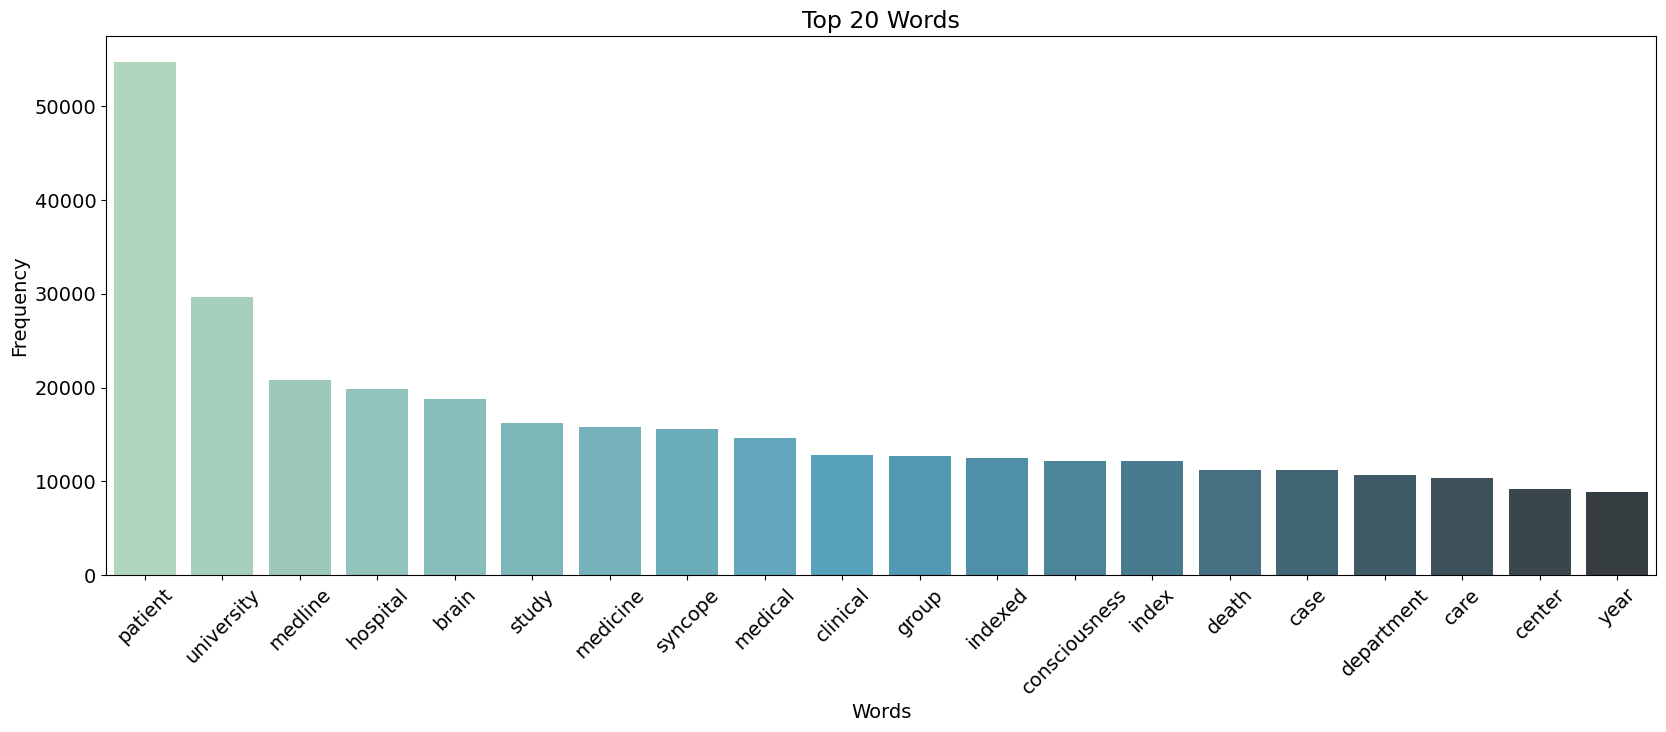

In [10]:
import seaborn as sns

# Plot a bar chart for the top 20 most frequently occuring words
fig = plt.figure(figsize=(20,7))

g = sns.barplot(
    x='word',
    y='frequency',
    data=top_20,
    palette='GnBu_d'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 20 Words', fontsize=17)

plt.show()

In [11]:
# Get the number of unique words after processing
num_unique_words = len(set(p_text))
num_unique_words

201960

In [12]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from collections import Counter
from operator import itemgetter

In [13]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = df['processed_text']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below = 3,
    no_above=0.85,
    #keep_n=5000, removed so that we're not setting a limit for number of words
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 75 + 1, 5))

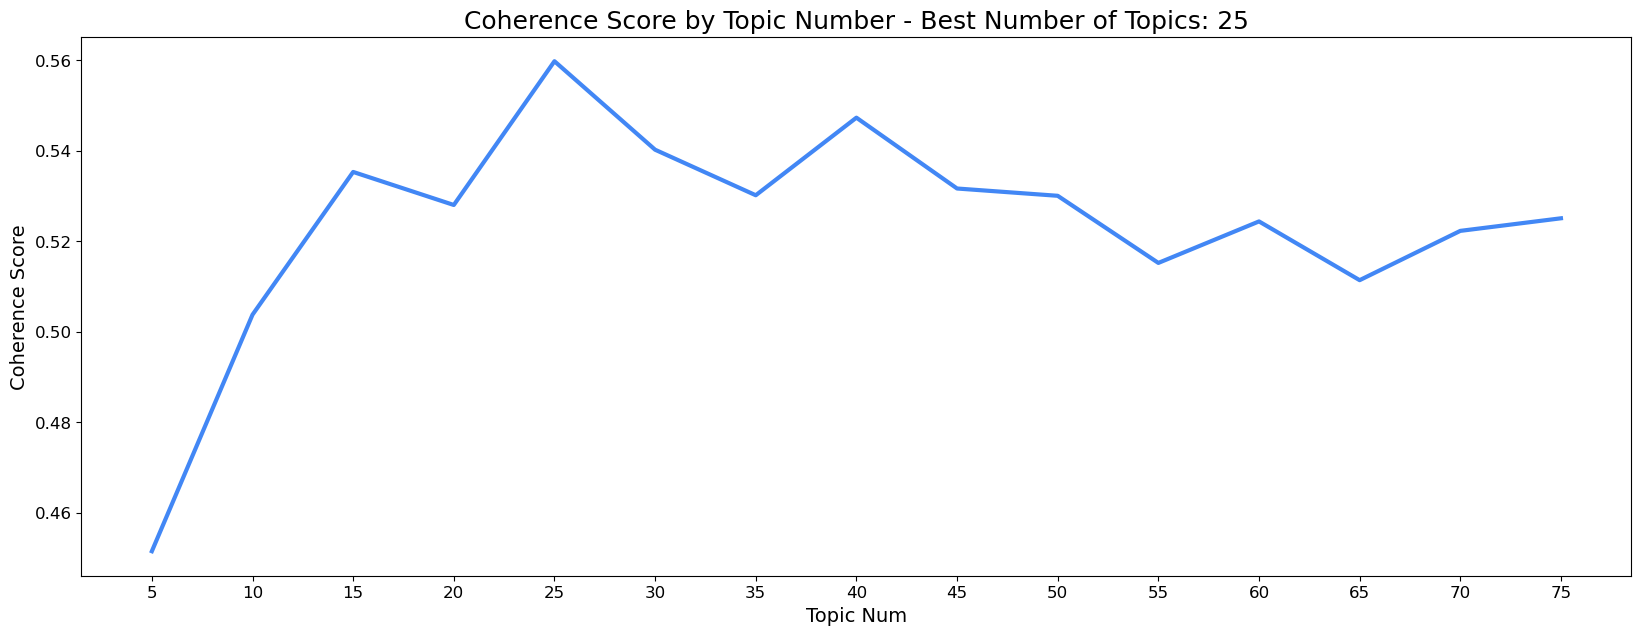

In [15]:
# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(20, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [16]:
# Now use the number of topics with the 
# highest coherence score to run the 
# sklearn nmf model

texts = df['processed_text']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    #max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42
).fit(tfidf)

In [17]:
#functions for creating topic display table 

from nltk.tokenize import TweetTokenizer, RegexpTokenizer

def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  

def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens

# Funtion to remove duplicate words
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist

In [18]:
# Use the top words for each cluster by tfidf weight
# to create 'topics'

# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 8

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df.head(best_num_topics) #This depends on output

,0,1,2,3,4,5,6,7,topics
0,patient,score,outcome,mortality,stroke,study,year,risk,patient score outcome mortality stroke study y...
1,donor,dcd,graft,liver,transplant,transplantation,kidney,recipient,donor dcd graft liver transplant transplantati...
2,syncope,patient,cause,diagnostic,cardiac,syncope patient,patient syncope,vasovagal,syncope patient cause diagnostic cardiac vasov...
3,emergency,emerg,emergency medicine,emerg med,med,medicine,ann emerg,emergency department,emergency emerg medicine med ann department
4,death,brain death,brain,determination,criterion,diagnosis brain,dead,diagnosis,death brain determination criterion diagnosis ...
5,sleep,disorder,experience,consciousness,health,cognitive,memory,mental,sleep disorder experience consciousness health...
6,case,report,yearold,present,symptom,syndrome,treatment,acute,case report yearold present symptom syndrome t...
7,engl med,engl,med,author reply,reply,nejmcpmid indexed,nejmcpmid,med aug,engl med author reply nejmcpmid indexed aug
8,organ,donation,donor,organ donation,organ donor,transplant,transplantation,family,organ donation donor transplant transplantatio...
9,state,mcs,patient,conscious,vegetative,consciousness,doc,minimally,state mcs patient conscious vegetative conscio...


In [19]:
# Create a df with only the created topics and topic num
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df 

,topic_num,topics
0,0,patient score outcome mortality stroke study y...
1,1,donor dcd graft liver transplant transplantati...
2,2,syncope patient cause diagnostic cardiac vasov...
3,3,emergency emerg medicine med ann department
4,4,death brain determination criterion diagnosis ...
5,5,sleep disorder experience consciousness health...
6,6,case report yearold present symptom syndrome t...
7,7,engl med author reply nejmcpmid indexed aug
8,8,organ donation donor transplant transplantatio...
9,9,state mcs patient conscious vegetative conscio...


In [20]:
# Creating a temp df with the url and topic num to join on
name = df['name'].tolist()

df_temp = pd.DataFrame({
    'name': name,
    'topic_num': docweights.argmax(axis=1)
})

# Merging to get the topic num with url
merged_topic = df_temp.merge(
    topic_df,
    on='topic_num',
    how='left'
)

# Merging with the original df
df_topics = pd.merge(
    df,
    merged_topic,
    on='name',
    how='left'
)

df_topics = df_topics.drop(
    'text',
    axis=1
)

df_topics.head(10)

,name,processed_text,word_count,topic_num,topics
0,10601807.txt,"[eur, neurol, simultaneous, assessment, brain,...",133,23,blood pressure orthostatic cerebral flow react...
1,10613939.txt,"[ann, emerg, med, jan, sxhypoglycemia, abcs, s...",163,18,child pediatric children pediatr year hospital...
2,10618329.txt,"[heart, jan, heartdiagnosis, carotid, sinus, h...",170,22,tilt test hut headup positive vasovagal
3,10618330.txt,"[heart, jan, heartclinical, features, adenosin...",203,22,tilt test hut headup positive vasovagal
4,10624990.txt,"[anesth, analg, jan, prolong, coma, quadripleg...",30,12,bioeth index medline pmid spmid informationa
5,10631230.txt,"[chest, jan, chestcocaineinduce, bradyarrhythm...",63,2,syncope patient cause diagnostic cardiac vasov...
6,10634522.txt,"[clin, nucl, med, jan, tcm, hexamethylpropylen...",208,4,death brain determination criterion diagnosis ...
7,10636153.txt,"[neurology, jan, wnlspontaneous, reflex, movem...",65,4,death brain determination criterion diagnosis ...
8,10636154.txt,"[neurology, jan, wnldecerebratelike, posture, ...",74,4,death brain determination criterion diagnosis ...
9,10636279.txt,"[coll, cardiol, jan, sfalse, positive, headup,...",200,16,group control significantly difference compare...


In [21]:
# Showing the 3 matrices we get witn nmf
A = tfidf_vectorizer.transform(texts) 
W = nmf.components_
H = nmf.transform(A)

print('A = {} x {}'.format(A.shape[0], A.shape[1])) #Document x Term
print('W = {} x {}'.format(W.shape[0], W.shape[1])) #Topic x Term
print('H = {} x {}'.format(H.shape[0], H.shape[1])) # Document x Topic

A = 23676 x 181355
W = 25 x 181355
H = 23676 x 25


In [22]:
#Save it
df_topics.to_csv('H_DocumentTopicMatrix.csv')
topic_df.to_csv("TopicList.csv")

In [27]:
#remove empty "processed_text" strings that are non-english
print("Initial number of papers: {}".format(len(df)))

df_relevant = df_topics[(df_topics.topics == "state mcs patient conscious vegetative consciousness doc minimally")]
df_relevant = df_relevant.append(df_topics[(df_topics.topics == "injury tbi brain traumatic head severe")])



print("Irrelevant papers removed: {}".format(len(df) - len(df_relevant)))
print("Papers Remaining: {}".format(len(df_relevant)))
df_relevant

Initial number of papers: 23676
Irrelevant papers removed: 21661
Papers Remaining: 2015


,name,processed_text,word_count,topic_num,topics
152,10775545.txt,"[brain, brainauditory, evoke, potential, spect...",247,9,state mcs patient conscious vegetative conscio...
207,10815840.txt,"[brain, inj, apr, early, indication, emergence...",104,9,state mcs patient conscious vegetative conscio...
212,10821024.txt,"[med, sci, law, apr, near, pvs, new, medicoleg...",107,9,state mcs patient conscious vegetative conscio...
226,10832265.txt,"[minerva, anestesiol, aprvegetative, state, pr...",130,9,state mcs patient conscious vegetative conscio...
229,10832834.txt,"[lancet, srestoration, thalamocortical, connec...",35,9,state mcs patient conscious vegetative conscio...
...,...,...,...,...,...
23591,36576237.txt,"[neurocase, dec, online, aheadof, printa, pilo...",209,10,injury tbi brain traumatic head severe
23602,36593347.txt,"[sci, rep, jan, sxa, model, estimate, brainste...",218,10,injury tbi brain traumatic head severe
23656,36714930.txt,"[lakartidningen, jan, treatment, traumatic, br...",136,10,injury tbi brain traumatic head severe
23662,36722240.txt,"[integr, neurosci, jan, jjintranscranial, dire...",224,10,injury tbi brain traumatic head severe


In [28]:
df_relevant.to_csv('H_RelevantDocumentTopicMatrix.csv')

In [29]:
print("{} number of abstracts in topic 9".format(df_relevant[df_relevant.topic_num == 9].shape[0]))

1133 number of abstracts in topic 3


In [30]:
print("{} number of abstracts in topic 10".format(df_relevant[df_relevant.topic_num == 10].shape[0]))

882 number of abstracts in topic 3


In [31]:
df_relevant['word_count'].describe()

count    2015.000000
mean      176.629777
std        69.933213
min        11.000000
25%       135.000000
50%       173.000000
75%       214.000000
max       980.000000
Name: word_count, dtype: float64

## 2.2 Create a subgroup from the Full Texts corpus using NMF

In [1]:
import functions

In [2]:
functions.outputs.make_csv("/Users/manojarachige/Documents/Coding/Projects/BMedScDOC2021/BMedScDOC_2023/Assets/PDFs_Valid", "txt")

In [3]:
#csv called corpus.csv saved to current working directory

In [4]:
import pandas as pd
import csv

df=pd.read_csv('corpus.csv', encoding = 'unicode_escape', encoding_errors = 'ignore', engine ='c')
df.head()

,name,text
0,10618329.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
1,10618330.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
2,10639523.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
3,10644795.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
4,10648373.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...


In [5]:
df['processed_text'] = df['text'].apply(functions.processing.preprocess)
df.head()

,name,text,processed_text
0,10618329.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[diagnosis, carotid, sinus, hypersensitivity, ..."
1,10618330.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[clinical, feature, adenosine, sensitive, sync..."
2,10639523.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[job, nameeditorialsrole, atrial, septostomy, ..."
3,10644795.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[short, reportfactor, ameliorate, aggravate, s..."
4,10648373.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[cerebral, blood, flow, vasovagal, syncopeindu..."


In [6]:
df["word_count"] = df["processed_text"].apply(lambda x: len(x))
#add in a line to remove 0 wc texts
df = df[~(df.word_count == 0)]


df.head()

,name,text,processed_text,word_count
0,10618329.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[diagnosis, carotid, sinus, hypersensitivity, ...",742
1,10618330.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[clinical, feature, adenosine, sensitive, sync...",2027
2,10639523.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[job, nameeditorialsrole, atrial, septostomy, ...",1062
3,10644795.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[short, reportfactor, ameliorate, aggravate, s...",1022
4,10648373.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[cerebral, blood, flow, vasovagal, syncopeindu...",1918


In [7]:
# Descriptive statistics for word count
df['word_count'].describe()
#95%CI Calculated: 

count     3498.000000
mean      2010.164380
std       1456.624003
min          5.000000
25%        904.000000
50%       1759.500000
75%       2780.500000
max      14622.000000
Name: word_count, dtype: float64

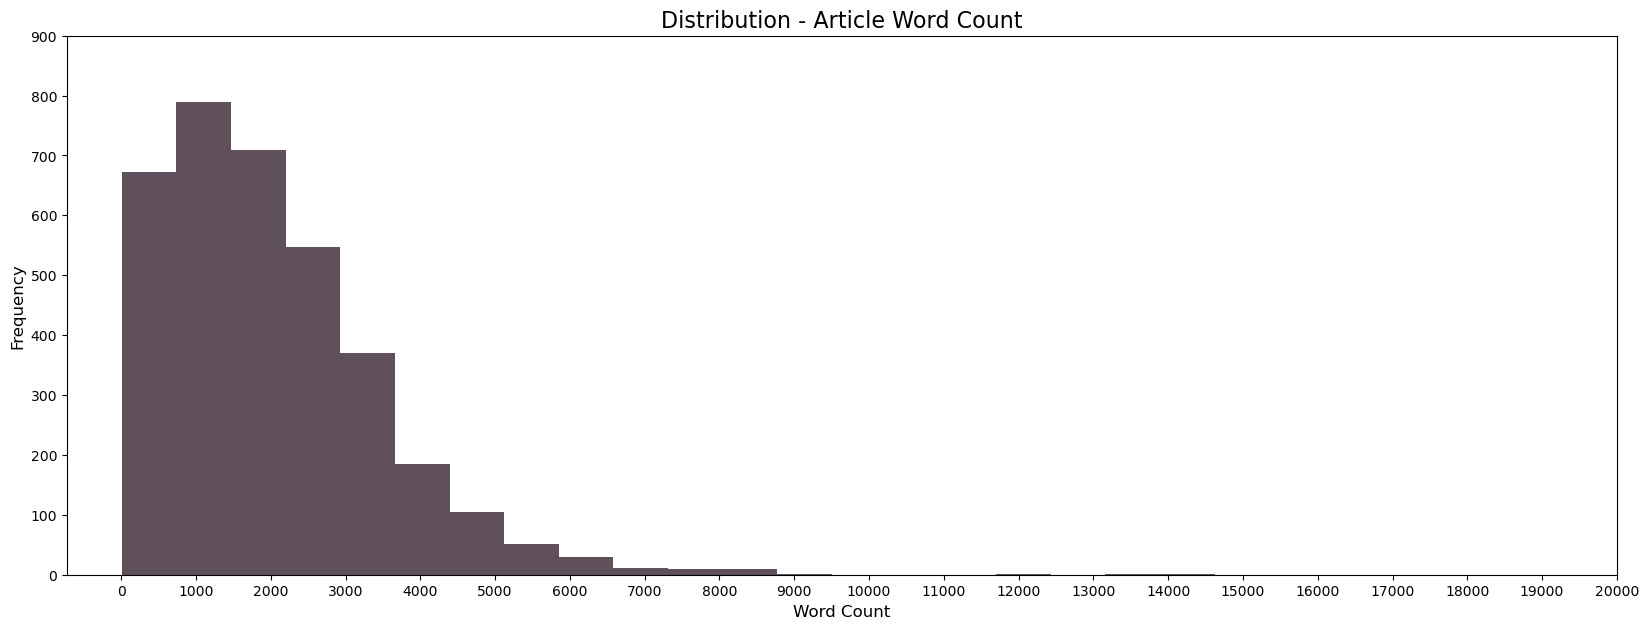

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Plot a hist of the word counts
fig = plt.figure(figsize=(20,7))

plt.hist(
    df['word_count'],
    bins=20,
    color='#60505C'
)

plt.title('Distribution - Article Word Count', fontsize=16)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Word Count', fontsize=12)
plt.yticks(np.arange(0, 1000, 100))
plt.xticks(np.arange(0, 21000, 1000))

file_name = 'hist'

plt.show()

In [9]:
from collections import Counter

# Get the top 20 most common words among all the articles
p_text = df['processed_text']

# Flaten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),
    columns=['word', 'frequency']
)

top_20

,word,frequency
0,patient,103986
1,study,45632
2,brain,36859
3,group,24301
4,clinical,21190
5,death,20661
6,case,19895
7,show,19077
8,time,19030
9,result,18734


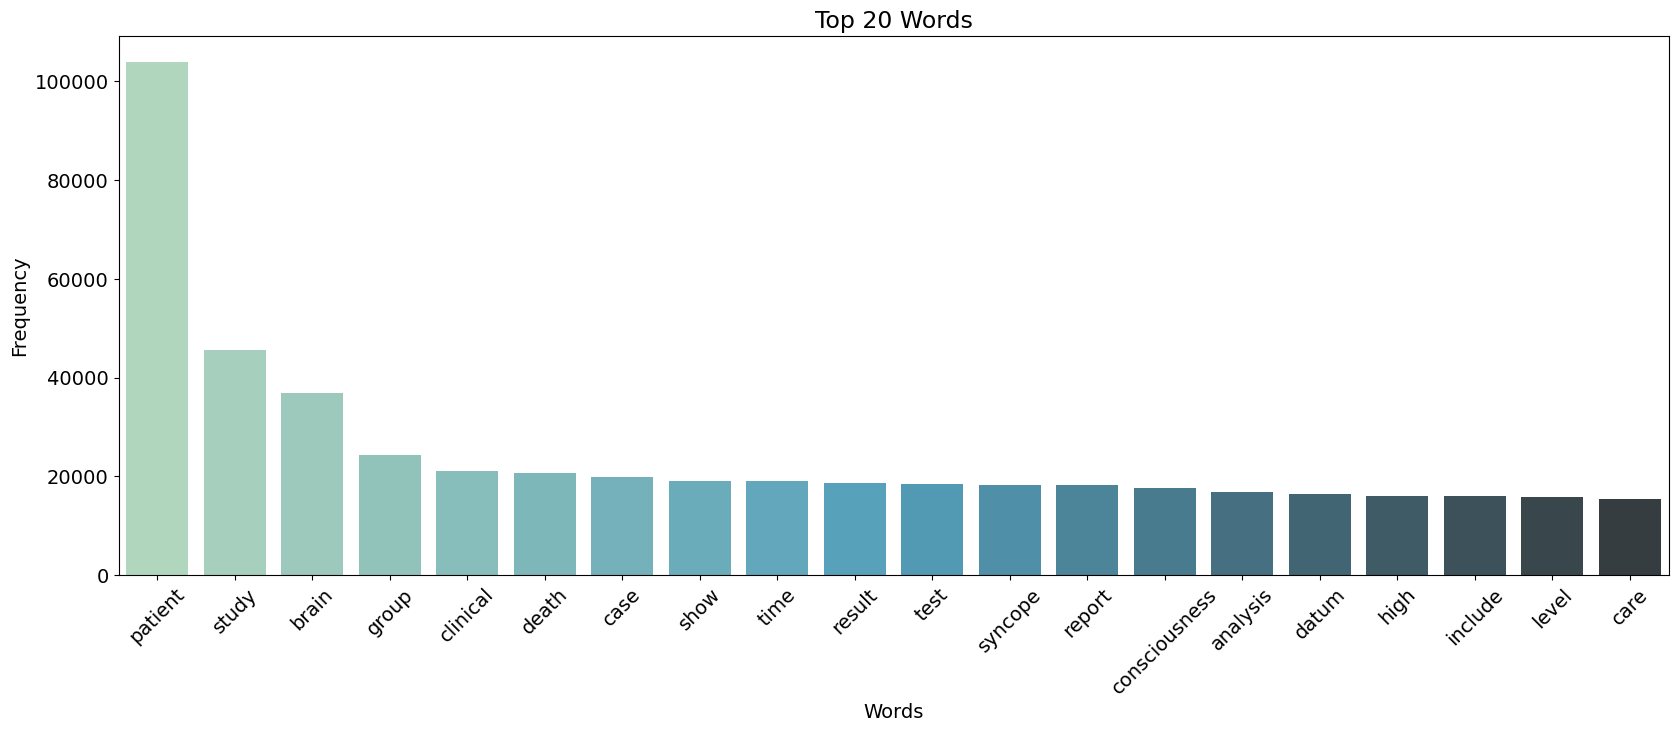

In [10]:
import seaborn as sns

# Plot a bar chart for the top 20 most frequently occuring words
fig = plt.figure(figsize=(20,7))

g = sns.barplot(
    x='word',
    y='frequency',
    data=top_20,
    palette='GnBu_d'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 20 Words', fontsize=17)

plt.show()

In [11]:
# Get the number of unique words after processing
num_unique_words = len(set(p_text))
num_unique_words

638198

In [12]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from collections import Counter
from operator import itemgetter

In [13]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = df['processed_text']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below = 3,
    no_above=0.85,
    #keep_n=5000, removed so that we're not setting a limit for number of words
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 75 + 1, 5))

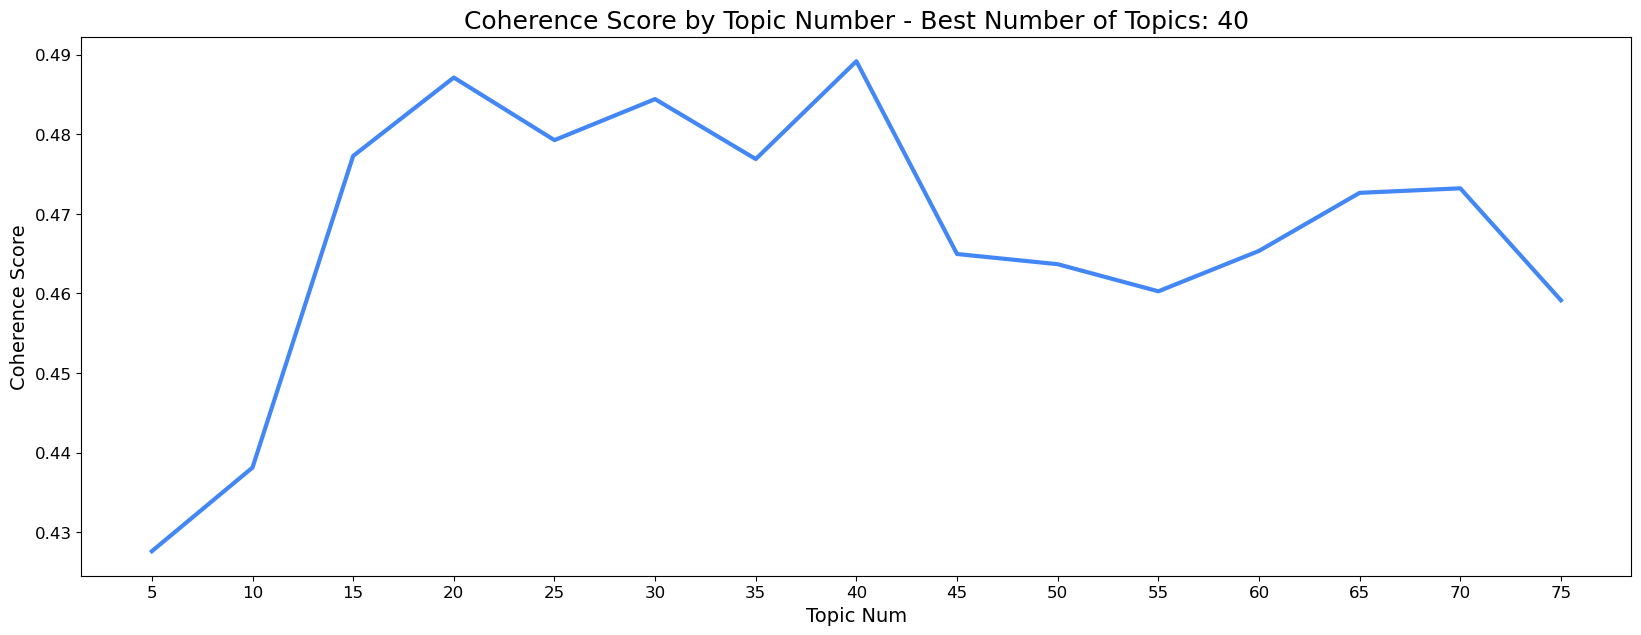

In [14]:
# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(20, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [15]:
# Now use the number of topics with the 
# highest coherence score to run the 
# sklearn nmf model

texts = df['processed_text']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    #max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42
).fit(tfidf)

In [16]:
#functions for creating topic display table 

from nltk.tokenize import TweetTokenizer, RegexpTokenizer

def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  

def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens

# Funtion to remove duplicate words
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist

In [17]:
# Use the top words for each cluster by tfidf weight
# to create 'topics'

# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 8

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df.head(best_num_topics)

,0,1,2,3,4,5,6,7,topics
0,mcs,doc,crsr,uws,consciousness,vsuws,disorder consciousness,vegetative,mcs doc crsr uws consciousness vsuws disorder ...
1,syncope,vasovagal,cardiac,vasovagal syncope,syncopal,cause,cause syncope,patient syncope,syncope vasovagal cardiac syncopal cause patient
2,death,brain death,brain,determination,dead,criterion,function,organ,death brain determination dead criterion funct...
3,coma,myxedema,serum,day,case,level,mgdl,ammonia,coma myxedema serum day case level mgdl ammonia
4,organ,donation,donor,organ donation,organ donor,donate,transplantation,braindead,organ donation donor donate transplantation br...
5,rat,animal,cell,group,expression,mouse,neuron,gene,rat animal cell group expression mouse neuron ...
6,arrest,cardiac arrest,cardiac,hypothermia,outcome,nse,resuscitation,cpc,arrest cardiac hypothermia outcome nse resusci...
7,eeg,power,alpha,electrode,ceeg,pattern,frequency,band,eeg power alpha electrode ceeg pattern frequen...
8,court,family,decision,care,life,vegetative,state,pvs,court family decision care life vegetative sta...
9,seizure,epilepsy,epileptic,ictal,epileptic seizure,convulsive,epilepticus,status epilepticus,seizure epilepsy epileptic ictal convulsive ep...


In [18]:
# Create a df with only the created topics and topic num
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df #There should be 10 topics based on coherence test

,topic_num,topics
0,0,mcs doc crsr uws consciousness vsuws disorder ...
1,1,syncope vasovagal cardiac syncopal cause patient
2,2,death brain determination dead criterion funct...
3,3,coma myxedema serum day case level mgdl ammonia
4,4,organ donation donor donate transplantation br...
5,5,rat animal cell group expression mouse neuron ...
6,6,arrest cardiac hypothermia outcome nse resusci...
7,7,eeg power alpha electrode ceeg pattern frequen...
8,8,court family decision care life vegetative sta...
9,9,seizure epilepsy epileptic ictal convulsive ep...


In [28]:
# Creating a temp df with the url and topic num to join on
name = df['name'].tolist()

df_temp = pd.DataFrame({
    'name': name,
    'topic_num': docweights.argmax(axis=1)
})

# Merging to get the topic num with url
merged_topic = df_temp.merge(
    topic_df,
    on='topic_num',
    how='left'
)

# Merging with the original df
df_topics = pd.merge(
    df,
    merged_topic,
    on='name',
    how='left'
)

df_topics = df_topics.drop(
    'text',
    axis=1
)

df_topics.head(10)

,name,processed_text,word_count,topic_num,topics
0,10618329.txt,"[diagnosis, carotid, sinus, hypersensitivity, ...",742,24,fall carotid sinus csm csh massage elderly
1,10618330.txt,"[clinical, feature, adenosine, sensitive, sync...",2027,34,tilt hut headup syncope test positive
2,10639523.txt,"[job, nameeditorialsrole, atrial, septostomy, ...",1062,39,coronary ventricular pulmonary artery right my...
3,10644795.txt,"[short, reportfactor, ameliorate, aggravate, s...",1022,33,disorder caregiver participant item personalit...
4,10648373.txt,"[cerebral, blood, flow, vasovagal, syncopeindu...",1918,10,pressure orthostatic blood heart rate autonomi...
5,10658984.txt,"[original, articleshigh, yield, criterion, eme...",1018,25,cta tcd cerebral flow angiography brain death ...
6,10659008.txt,"[letter, tothe, editoracute, myocardial, infar...",2461,39,coronary ventricular pulmonary artery right my...
7,10663290.txt,"[introductioncongenital, acth, deficiency, rar...",1002,3,coma myxedema serum day case level mgdl ammonia
8,10663466.txt,"[introductioncryptococcus, neoformans, bud, no...",536,12,lesion mri image dwi matter adc white imaging
9,10663515.txt,"[receive, january, accept, july, barne, robson...",2275,16,tbi injury traumatic brain head mtbi


In [29]:
# Showing the 3 matrices we get witn nmf
A = tfidf_vectorizer.transform(texts) 
W = nmf.components_
H = nmf.transform(A)

print('A = {} x {}'.format(A.shape[0], A.shape[1])) #Document x Term
print('W = {} x {}'.format(W.shape[0], W.shape[1])) #Topic x Term
print('H = {} x {}'.format(H.shape[0], H.shape[1])) # Document x Topic

A = 3498 x 347747
W = 40 x 347747
H = 3498 x 40


In [30]:
#Save it
df_topics.to_csv('H_DocumentTopicMatrix.csv')
topic_df.to_csv("TopicList.csv")

In [31]:
#remove empty "processed_text" strings that are non-english
print("Initial number of papers: {}".format(len(df)))

#remove all texts that don't align with relevant topics
df_relevant = df_topics[(df_topics.topics == "mcs doc crsr uws consciousness vsuws disorder vegetative")]
df_relevant = df_relevant.append(df_topics[(df_topics.topics == "tbi injury traumatic brain head mtbi")])
df_relevant = df_relevant.append(df_topics[(df_topics.topics == "connectivity network functional brain region consciousness cortex")])
df_relevant = df_relevant.append(df_topics[(df_topics.topics == "score gcs scale coma outcome glasgow")])



print("Irrelevant papers removed: {}".format(len(df) - len(df_relevant)))
print("Papers Remaining: {}".format(len(df_relevant)))
df_relevant.head(10)

Initial number of papers: 3498
Irrelevant papers removed: 3215
Papers Remaining: 283


,name,processed_text,word_count,topic_num,topics
962,19622138.txt,"[biome, centralbmc, neurologyssopen, acceresea...",1780,0,mcs doc crsr uws consciousness vsuws disorder ...
1263,22081100.txt,"[original, communicationfunctional, neuroanato...",817,0,mcs doc crsr uws consciousness vsuws disorder ...
1842,25880206.txt,"[cerebral, response, subject, show, high, prog...",3691,0,mcs doc crsr uws consciousness vsuws disorder ...
1848,25893211.txt,"[resource, reviewcare, neurorehabilitation, di...",2594,0,mcs doc crsr uws consciousness vsuws disorder ...
1862,25957644.txt,"[clinical, electroencephalographic, onoff, eff...",788,0,mcs doc crsr uws consciousness vsuws disorder ...
1931,26450569.txt,"[coma, recovery, scaler, variability, disorder...",2313,0,mcs doc crsr uws consciousness vsuws disorder ...
2067,27359335.txt,"[outcome, prediction, consciousness, disorder,...",3553,0,mcs doc crsr uws consciousness vsuws disorder ...
2241,28621625.txt,"[editorial, thalamic, stimulation, vegetative,...",552,0,mcs doc crsr uws consciousness vsuws disorder ...
2300,28946586.txt,"[neurorehabilitation, doinreio, presscase, rep...",952,0,mcs doc crsr uws consciousness vsuws disorder ...
2381,29623396.txt,"[resistance, eye, opening, patient, disorder, ...",1739,0,mcs doc crsr uws consciousness vsuws disorder ...


In [32]:
df_relevant.to_csv('H_RelevantDocumentTopicMatrix.csv')

In [34]:
print("{} number of papers in topic 0".format(df_relevant[df_relevant.topic_num == 0].shape[0]))

30 number of papers in topic 0


In [35]:
print("{} number of papers in topic 16".format(df_relevant[df_relevant.topic_num == 16].shape[0]))

88 number of papers in topic 16


In [36]:
print("{} number of papers in topic 21".format(df_relevant[df_relevant.topic_num == 21].shape[0]))

103 number of papers in topic 21


In [37]:
print("{} number of papers in topic 26".format(df_relevant[df_relevant.topic_num == 26].shape[0]))

62 number of papers in topic 26


In [38]:
df_relevant['word_count'].describe()

count     283.000000
mean     2894.855124
std      1515.085611
min       193.000000
25%      1884.000000
50%      2631.000000
75%      3738.500000
max      8509.000000
Name: word_count, dtype: float64

And with that, we've created 2x subgroups with NMF

- An NMF subgroup of the abstracts (2015)
- An NMF subgroup of the full texts (283)

## 2.3 Separate the corpus into 4 mutually exclusive corpora

- NMF Abstracts (2015)
- Non-NMF Abstracts (24,239 - 2015 = 22,224)
- NMF Full Texts (283)
- Non-NMF Full Texts (3780 - 283 = 3497)

### 2.3.1 Separate Abstracts

In [39]:
import shutil
import pandas as pd
import os
import csv

In [40]:
#Separate Abstracts

df = pd.read_csv("/Users/manojarachige/Library/CloudStorage/Dropbox/Mac/Documents/Coding/Projects/BMedScDOC2021/BMedScDOC_2023/Outputs/Subgrouping_Abstracts/H_RelevantDocumentTopicMatrix.csv")

In [41]:
df

,Unnamed: 0,name,processed_text,word_count,topic_num,topics
0,152,10775545.txt,"['brain', 'brainauditory', 'evoke', 'potential...",247,9,state mcs patient conscious vegetative conscio...
1,207,10815840.txt,"['brain', 'inj', 'apr', 'early', 'indication',...",104,9,state mcs patient conscious vegetative conscio...
2,212,10821024.txt,"['med', 'sci', 'law', 'apr', 'near', 'pvs', 'n...",107,9,state mcs patient conscious vegetative conscio...
3,226,10832265.txt,"['minerva', 'anestesiol', 'aprvegetative', 'st...",130,9,state mcs patient conscious vegetative conscio...
4,229,10832834.txt,"['lancet', 'srestoration', 'thalamocortical', ...",35,9,state mcs patient conscious vegetative conscio...
...,...,...,...,...,...,...
2010,23591,36576237.txt,"['neurocase', 'dec', 'online', 'aheadof', 'pri...",209,10,injury tbi brain traumatic head severe
2011,23602,36593347.txt,"['sci', 'rep', 'jan', 'sxa', 'model', 'estimat...",218,10,injury tbi brain traumatic head severe
2012,23656,36714930.txt,"['lakartidningen', 'jan', 'treatment', 'trauma...",136,10,injury tbi brain traumatic head severe
2013,23662,36722240.txt,"['integr', 'neurosci', 'jan', 'jjintranscrania...",224,10,injury tbi brain traumatic head severe


In [42]:
list = df["name"].tolist()

In [44]:
for doc in os.listdir("/Users/manojarachige/Library/CloudStorage/Dropbox/Mac/Documents/Coding/Projects/BMedScDOC2021/BMedScDOC_2023/Assets/Abstracts_All"):
    if doc in list:
        shutil.copy("/Users/manojarachige/Library/CloudStorage/Dropbox/Mac/Documents/Coding/Projects/BMedScDOC2021/BMedScDOC_2023/Assets/Abstracts_All/" + doc, "/Users/manojarachige/Library/CloudStorage/Dropbox/Mac/Documents/Coding/Projects/BMedScDOC2021/BMedScDOC_2023/Assets/Abstracts_TM")
    else:
        shutil.copy("/Users/manojarachige/Library/CloudStorage/Dropbox/Mac/Documents/Coding/Projects/BMedScDOC2021/BMedScDOC_2023/Assets/Abstracts_All/" + doc, "/Users/manojarachige/Library/CloudStorage/Dropbox/Mac/Documents/Coding/Projects/BMedScDOC2021/BMedScDOC_2023/Assets/Abstracts_NON_TM")

### 2.3.1 Separate Full Texts

In [1]:
import shutil
import pandas as pd
import os
import csv

In [2]:
#Separate Full Texts

df = pd.read_csv("/Users/manojarachige/Library/CloudStorage/Dropbox/Mac/Documents/Coding/Projects/BMedScDOC2021/BMedScDOC_2023/Outputs/Subgrouping_FullTexts/H_RelevantDocumentTopicMatrix.csv")

In [3]:
df

,Unnamed: 0,name,processed_text,word_count,topic_num,topics
0,962,19622138.txt,"['biome', 'centralbmc', 'neurologyssopen', 'ac...",1780,0,mcs doc crsr uws consciousness vsuws disorder ...
1,1263,22081100.txt,"['original', 'communicationfunctional', 'neuro...",817,0,mcs doc crsr uws consciousness vsuws disorder ...
2,1842,25880206.txt,"['cerebral', 'response', 'subject', 'show', 'h...",3691,0,mcs doc crsr uws consciousness vsuws disorder ...
3,1848,25893211.txt,"['resource', 'reviewcare', 'neurorehabilitatio...",2594,0,mcs doc crsr uws consciousness vsuws disorder ...
4,1862,25957644.txt,"['clinical', 'electroencephalographic', 'onoff...",788,0,mcs doc crsr uws consciousness vsuws disorder ...
...,...,...,...,...,...,...
278,3227,34893971.txt,"['clinical', 'characteristic', 'outcomes', 'ch...",3518,26,score gcs scale coma outcome glasgow
279,3244,35045397.txt,"['wwwaginguscom', 'age', 'introduction', 'prol...",2124,26,score gcs scale coma outcome glasgow
280,3413,36068496.txt,"['validity', 'early', 'functional', 'ability',...",3652,26,score gcs scale coma outcome glasgow
281,3420,36131183.txt,"['temporary', 'permanent', 'clinical', 'challe...",2184,26,score gcs scale coma outcome glasgow


In [4]:
list = df["name"].tolist()

In [5]:
for doc in os.listdir("/Users/manojarachige/Library/CloudStorage/Dropbox/Mac/Documents/Coding/Projects/BMedScDOC2021/BMedScDOC_2023/Assets/PDFs_Valid"):
    if doc in list:
        shutil.copy("/Users/manojarachige/Library/CloudStorage/Dropbox/Mac/Documents/Coding/Projects/BMedScDOC2021/BMedScDOC_2023/Assets/PDFs_Valid/" + doc, "/Users/manojarachige/Library/CloudStorage/Dropbox/Mac/Documents/Coding/Projects/BMedScDOC2021/BMedScDOC_2023/Assets/FullTexts_TM")
    else:
        shutil.copy("/Users/manojarachige/Library/CloudStorage/Dropbox/Mac/Documents/Coding/Projects/BMedScDOC2021/BMedScDOC_2023/Assets/PDFs_Valid/" + doc, "/Users/manojarachige/Library/CloudStorage/Dropbox/Mac/Documents/Coding/Projects/BMedScDOC2021/BMedScDOC_2023/Assets/FullTexts_NON_TM")

Now there are 4 folders in total containing mutually exclusive texts

- NMF Abstracts (2015)
- Non-NMF Abstracts (2,224)
- NMF Full Texts (283)
- Non-NMF Full Texts (3497)